# Create model of one quantum dot

Using true values, plot the determinant of the fisher information and compute the inverse of the fisher information

In [1]:
import jax
import jax.numpy as jnp
from qdots_qll.models.game import *

import qutip as qt

import matplotlib.pyplot as plt

from qbism import sic_povm

import jax.typing

import equinox as eqx


from jax import Array

# from jax.typing import ArrayLike
from jaxtyping import Array, Float, Complex, Int

In [2]:
seed = 3
rho_ex = qt.rand_dm_ginibre(2, seed=seed)

In [3]:
class base_class_dimension(eqx.Module):
    d: int
    matrix_d: Float[Array, "d d"]
    positive_eps: Float

    def __init__(
        self,
        dimension: int,
    ) -> None:
        self.d = dimension
        self.matrix_d = jnp.ones([self.d, self.d])
        self.positive_eps = 1e-8

    @jit
    def vec(self, rho: Complex[Array, "d d"]) -> Complex[Array, "d**2"]:
        return rho.flatten()

    @jit
    def sprepost(
        self, A: Complex[Array, "d1 d2"], B: Complex[Array, "d3 d4"]
    ) -> Float[Array, "d1*d3 d2*d4"]:
        return jnp.kron(A, B.T)

    @jit
    def spre(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        d = A.shape[0]
        return self.sprepost(A, jnp.identity(d))

    @jit
    def spost(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        d = A.shape[0]

        return self.sprepost(jnp.identity(d), A)

In [4]:
check_nan = jax.jit(
    lambda a: jax.lax.cond(jnp.isnan(a), lambda a: 0.0, lambda a: a, a)
)


@jit
def compute_P_superop(
    evolved_state_vec: Complex[Array, "d**2"],
    POVM_element_vec: Complex[Array, "d**2"],
):

    return check_nan(
        jnp.real(jnp.dot(dag(POVM_element_vec), evolved_state_vec))
    )


@jit
def compute_P_matrix_ver(
    evolved_state: Complex[Array, "d d"],
    POVM_element: Complex[Array, "d d"],
):

    return check_nan(jnp.real(jnp.trace(evolved_state @ POVM_element)))


class single_qdot(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    system_hamiltonian: Complex[Array, "d d"]
    A: Complex[Array, "d d"]
    POVM_arr: Complex[Array, "no_outcomes d d"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes d d"]):
        super().__init__(dimension=2)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.system_hamiltonian = self.make_system_hamiltonian()
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_system_hamiltonian(self) -> Complex[Array, "d d"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "d**2 d**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "d**2 d**2"],
        initial_state: Complex[Array, "d**2"],
    ) -> Complex[Array, "d**2"]:
        return expm(t * liouvillian) @ initial_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_liouvillian(particle)
        evolved_state = self.evolve_initial_state_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_liouvillian(
                t, self.make_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

In [5]:
check_nan = jax.jit(
    lambda a: jax.lax.cond(jnp.isnan(a), lambda a: 0.0, lambda a: a, a)
)


@jit
def compute_P_superop(
    evolved_state_vec: Complex[Array, "d**2"],
    POVM_element_vec: Complex[Array, "d**2"],
):

    return check_nan(
        jnp.real(jnp.dot(dag(POVM_element_vec), evolved_state_vec))
    )


@jit
def compute_P_matrix_ver(
    evolved_state: Complex[Array, "d d"],
    POVM_element: Complex[Array, "d d"],
):

    return check_nan(jnp.real(jnp.trace(evolved_state @ POVM_element)))


class two_qdots_separable_maps(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    one_dot_system_hamiltonian: Complex[Array, "2 2"]
    A: Complex[Array, "2 2"]
    POVM_arr: Complex[Array, "no_outcomes 4 4"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes 4 4"]):
        super().__init__(dimension=4)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.one_dot_system_hamiltonian = (
            self.make_one_dot_system_hamiltonian()
        )
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_one_dot_system_hamiltonian(self) -> Complex[Array, "2 2"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_one_dot_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "2**2 2**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.one_dot_system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.one_dot_system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_with_one_dot_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "2**2 2**2"],
        initial_state: Complex[Array, "4**2"],
    ) -> Complex[Array, "4**2"]:

        # This is the tricky part, we take the liouvillian, and then
        # we will apply both exp(L) to each qubit, carefully.
        # Remember the liouvillian is only for one dot

        map_A = expm(t * liouvillian)
        map_B = map_A

        total_map_superop = jnp.kron(
            map_A, map_B
        )  # this now is a superop in 16x16

        # Now the initial state needs to be reshape to 2, 2, 2, 2
        # swap the 2nd and 3d index.
        # vectorize
        # apply the total_map_superop
        # convert to 2, 2, 2, 2
        # unswap 2nd and 3rd
        # vectorize
        evolved_state = vec(
            (
                total_map_superop
                @ vec(
                    initial_state.reshape([2, 2, 2, 2])
                    .swapaxes(1, 2)
                    .reshape([4, 4])
                )
            )
            .reshape([2, 2, 2, 2])
            .swapaxes(1, 2)
            .reshape([4, 4])
        )

        return evolved_state

    # @jit
    # def evolve_initial_state_with_one_dot_liouvillian(
    #     self,
    #     t: Float,
    #     liouvillian: Complex[Array, "2**2 2**2"],
    #     initial_state: Complex[Array, "4**2"],
    # ) -> Complex[Array, "4**2"]:

    #     # This is the tricky part, we take the liouvillian, and then
    #     # we will apply both exp(L) to each qubit, carefully.
    #     # Remember the liouvillian is only for one dot

    #     map_A = expm(t * liouvillian)
    #     map_B = map_A

    #     total_map_superop = jnp.kron(
    #          jnp.identity(4), map_A
    #     )  # this now is a superop in 16x16

    #     # Now the initial state needs to be reshape to 2, 2, 2, 2
    #     # swap the 2nd and 3d index.
    #     # vectorize
    #     # apply the total_map_superop
    #     # convert to 2, 2, 2, 2
    #     # unswap 2nd and 3rd
    #     # vectorize
    #     evolved_state = vec(
    #         (
    #             total_map_superop
    #             @ vec(initial_state.reshape([2, 2, 2, 2]).swapaxes(1, 2).reshape([4, 4]))
    #         )
    #         .reshape([2, 2, 2, 2])
    #         .swapaxes(1, 2)
    #         .reshape([4, 4])
    #     )

    #     return evolved_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "4**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_one_dot_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_with_one_dot_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        # example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

    @jit
    def qfim_with_inverse(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        middle_product = jnp.linalg.inv(
            jnp.kron(evolved_state, jnp.identity(d))
            + jnp.kron(
                jnp.identity(d),
                jnp.conjugate(evolved_state),
            )
        )

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, -1
        )  # first index is related to the parameter

        qfim = 2 * jnp.einsum(
            "iv, vw, jw",
            jnp.conjugate(partial_rhoi_parameterj),
            middle_product,
            partial_rhoi_parameterj,
        )

        return qfim

    @jit
    def make_SLD(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        # eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(
            particle.astype(jnp.complex64)
        ).T  # first index is related to the parameter

        sld = jnp.einsum(
            "jk, ik -> ij",
            2
            * jnp.linalg.inv(
                jnp.kron(evolved_state, jnp.identity(d))
                + jnp.kron(
                    jnp.identity(d),
                    evolved_state,
                )
            ),
            partial_rhoi_parameterj,
        )

        return sld

In [6]:
class two_qdots_identity_for_systemB(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    one_dot_system_hamiltonian: Complex[Array, "2 2"]
    A: Complex[Array, "2 2"]
    POVM_arr: Complex[Array, "no_outcomes 4 4"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes 4 4"]):
        super().__init__(dimension=4)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.one_dot_system_hamiltonian = (
            self.make_one_dot_system_hamiltonian()
        )
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_one_dot_system_hamiltonian(self) -> Complex[Array, "2 2"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_one_dot_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "2**2 2**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.one_dot_system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.one_dot_system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_with_one_dot_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "2**2 2**2"],
        initial_state: Complex[Array, "4**2"],
    ) -> Complex[Array, "4**2"]:

        # This is the tricky part, we take the liouvillian, and then
        # we will apply both exp(L) to each qubit, carefully.
        # Remember the liouvillian is only for one dot

        map_A = expm(t * liouvillian)

        total_map_superop = jnp.kron(
            map_A, jnp.identity(4)
        )  # this now is a superop in 16x16

        # Now the initial state needs to be reshape to 2, 2, 2, 2
        # swap the 2nd and 3d index.
        # vectorize
        # apply the total_map_superop
        # convert to 2, 2, 2, 2
        # unswap 2nd and 3rd
        # vectorize
        evolved_state = vec(
            (
                total_map_superop
                @ vec(
                    initial_state.reshape([2, 2, 2, 2])
                    .swapaxes(1, 2)
                    .reshape([4, 4])
                )
            )
            .reshape([2, 2, 2, 2])
            .swapaxes(1, 2)
            .reshape([4, 4])
        )

        return evolved_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "4**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_one_dot_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_with_one_dot_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

# Choi case

In [7]:
from functools import reduce

list_ket_ii = [qt.tensor(qt.basis(2, i), qt.basis(2, i)) for i in range(2)]

ket_ii = reduce(lambda i, j: i + j, list_ket_ii).unit()

rho_omega_super = vec(
    qt.ket2dm(ket_ii).full()
)  # maximally entangled state (|omega><omega|)

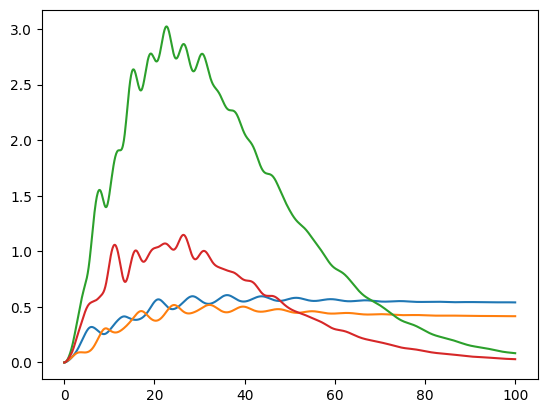

In [8]:
m = two_qdots_identity_for_systemB(POVM_array=jnp.array(sic_povm(4)))

initial_state = rho_omega_super

times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)


# plt.plot(times, evolved_lkl[:, 0])

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, initial_state))(times)

for i in range(4):
    plt.plot(times, evolution_fim[:, i, i])

plt.show()

In [69]:
diagonalized_fisher_times = jax.vmap(
    lambda t: (jnp.linalg.eigh(m.fim(true_pars, t, initial_state))[0])
)(times)

In [87]:
diagonalized_inv_fisher_times = jax.vmap(
    lambda t: (
        jnp.linalg.eigh(jnp.linalg.inv(m.fim(true_pars, t, initial_state)))[0]
    )
)(times)

In [9]:
evolution_det_fim = jax.vmap(
    lambda t: jnp.linalg.det(m.fim(true_pars, t, initial_state))
)(times)

In [10]:
evolution_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.inv(m.fim(true_pars, t, initial_state))
)(times)

In [37]:
evolution_inverse_fim[:, 0, 0]

Array([           nan, 3.62972778e+03, 9.94117676e+02, 4.81057770e+02,
       2.92719330e+02, 2.01326630e+02, 1.49262787e+02, 1.16322258e+02,
       9.38774185e+01, 7.77224197e+01, 6.56021729e+01, 5.62197990e+01,
       4.87887192e+01, 4.28105888e+01, 3.79558258e+01, 3.39938431e+01,
       3.07510376e+01, 2.80864372e+01, 2.58792992e+01, 2.40250893e+01,
       2.24352608e+01, 2.10378342e+01, 1.97769947e+01, 1.86116428e+01,
       1.75129910e+01, 1.64623108e+01, 1.54487276e+01, 1.44673805e+01,
       1.35179539e+01, 1.26032801e+01, 1.17280807e+01, 1.08978977e+01,
       1.01180096e+01, 9.39267349e+00, 8.72458839e+00, 8.11466885e+00,
       7.56207323e+00, 7.06443930e+00, 6.61825418e+00, 6.21927118e+00,
       5.86290598e+00, 5.54454374e+00, 5.25984001e+00, 5.00484800e+00,
       4.77615070e+00, 4.57088232e+00, 4.38669300e+00, 4.22173309e+00,
       4.07451820e+00, 3.94387197e+00, 3.82880712e+00, 3.72840929e+00,
       3.64178753e+00, 3.56800580e+00, 3.50606370e+00, 3.45492268e+00,
      

In [38]:
jnp.nanmin(evolution_inverse_fim[:, 0, 0])

Array(2.1117072, dtype=float32)

In [43]:
times[jnp.argmin(evolution_inverse_fim[1:, 0, 0])]

Array(20.62062, dtype=float32)

In [50]:
jnp.nanmin(evolution_inverse_fim[:, :, :], axis=0)

Array([[ 2.1117072e+00, -2.8402536e+02, -7.3913848e-01, -9.2817849e-01],
       [-2.8402533e+02,  2.2963121e+00, -1.5338760e+02, -3.0437427e+02],
       [-7.3913848e-01, -1.5338757e+02,  9.0302241e-01,  1.9841968e-01],
       [-9.2817855e-01, -3.0437421e+02,  1.9841969e-01,  2.1423457e+00]],      dtype=float32)

Text(0.5, 1.0, 'Inverse of the FIM')

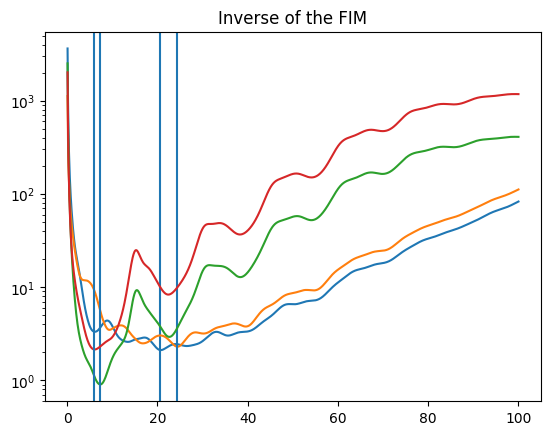

In [119]:
for i in range(4):
    plt.plot(times, evolution_inverse_fim[:, i, i])
    plt.axvline(times[jnp.argmin(evolution_inverse_fim[1:, i, i])])

plt.yscale("log")
plt.title("Inverse of the FIM")

In [129]:
inverse_matrix_scaling

Array([[          inf,           inf,           inf,           inf],
       [2.1117073e-02, 2.2963120e-02, 9.0302238e-03, 2.1423455e-02],
       [1.0558536e-02, 1.1481560e-02, 4.5151119e-03, 1.0711728e-02],
       ...,
       [2.1117705e-07, 2.2963810e-07, 9.0304951e-08, 2.1424100e-07],
       [2.1117494e-07, 2.2963580e-07, 9.0304042e-08, 2.1423885e-07],
       [2.1117283e-07, 2.2963351e-07, 9.0303146e-08, 2.1423672e-07]],      dtype=float32)

In [127]:
jnp.diag(jnp.nanmin(evolution_inverse_fim[1:], axis=0))

Array([2.1117072, 2.296312 , 0.9030224, 2.1423457], dtype=float32)

In [97]:
jnp.nanmax(diagonalized_fisher_times[1:], axis=0)

Array([0.19404356, 0.3327945 , 0.9347784 , 4.024865  ], dtype=float32)

In [95]:
jnp.nanmin(diagonalized_inv_fisher_times[1:], axis=0)

Array([0.24845573, 1.0697716 , 3.004859  , 5.1534843 ], dtype=float32)

Text(0.5, 1.0, 'Diagonalized  inv fisher')

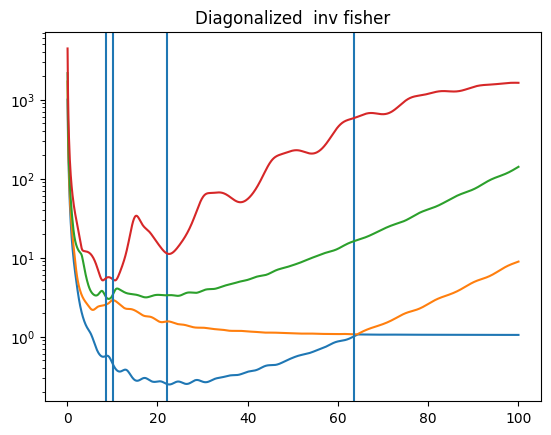

In [94]:
for i in range(4):
    plt.plot(times, diagonalized_inv_fisher_times[:, i])
    plt.axvline(times[jnp.argmin(diagonalized_inv_fisher_times[5:, i])])

# plt.plot(times, diagonalized_fisher_times[:, 3])

plt.yscale("log")
plt.title("Diagonalized  inv fisher")

Text(0.5, 1.0, 'Diagonalized fisher')

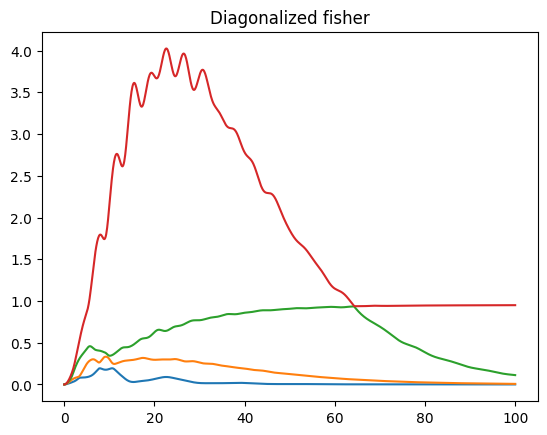

In [83]:
for i in range(4):
    plt.plot(times, diagonalized_fisher_times[:, i])
    # plt.axvline(times[jnp.argmax(diagonalized_fisher_times[1:, i])])

# plt.plot(times, diagonalized_fisher_times[:, 3])

# plt.yscale('log')
plt.title("Diagonalized fisher")

Text(0.5, 1.0, 'FIM')

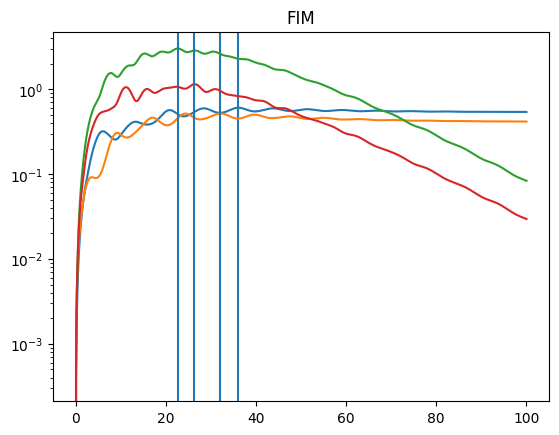

In [63]:
for i in range(4):
    plt.plot(times, evolution_fim[:, i, i])
    plt.axvline(times[jnp.argmax(evolution_fim[1:, i, i])])


plt.yscale("log")
plt.title("FIM")

In [53]:
jnp.diag(jnp.nanmin(evolution_inverse_fim[:, :, :], axis=0))

Array([2.1117072, 2.296312 , 0.9030224, 2.1423457], dtype=float32)

In [47]:
times[jnp.diag(jnp.argmin(evolution_inverse_fim[1:, :, :], axis=0))]

Array([20.62062  , 24.324324 ,  7.207207 ,  6.0060062], dtype=float32)

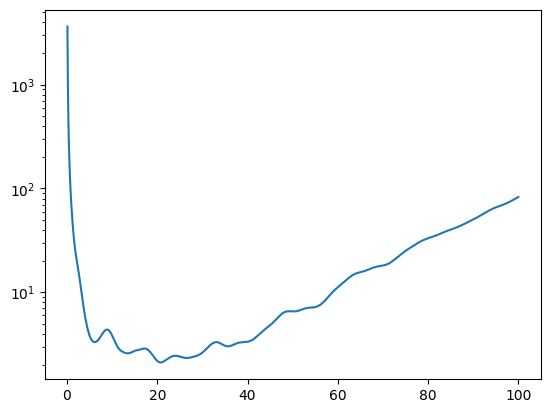

In [30]:
plt.plot(times, evolution_inverse_fim[:, 0, 0])

plt.yscale("log")

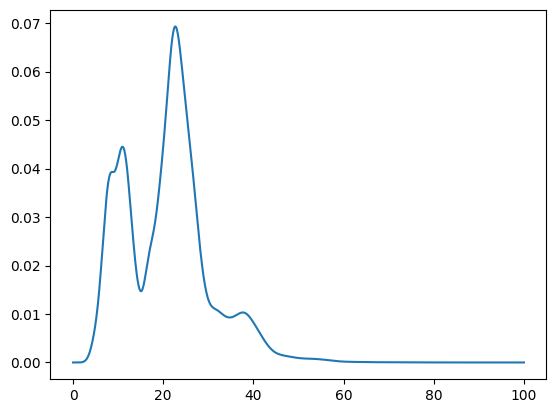

In [11]:
plt.plot(times, evolution_det_fim, label="det fim")

In [12]:
times[jnp.argmax(evolution_det_fim)]

Array(22.722723, dtype=float32)

In [13]:
jax.vmap(lambda a: 1 / jax.max(a[i, i]))

<function __main__.<lambda>(a)>

In [14]:
factor_inverse_matrix

NameError: name 'factor_inverse_matrix' is not defined

In [15]:
plt.plot(inverse_matrix_scaling.T[0])
plt.xscale("log")
plt.yscale("log")

NameError: name 'inverse_matrix_scaling' is not defined

In [182]:
evolution_inverse_fim[10:].T.shape

(4, 4, 990)

In [186]:
jnp.max(evolution_fim[10:], axis=0)

Array([[ 6.0600019e-01, -5.8607832e-03,  1.3790198e-01,  9.5071703e-02],
       [-5.8607832e-03,  5.1808470e-01,  2.2299916e-01,  6.7216761e-02],
       [ 1.3790198e-01,  2.2299916e-01,  3.0225539e+00,  7.1672490e-04],
       [ 9.5071703e-02,  6.7216761e-02,  7.1672490e-04,  1.1477792e+00]],      dtype=float32)

In [16]:
jax.vmap(lambda A: jnp.min(A))(evolution_inverse_fim[10:].T)

jnp.min(
    evolution_inverse_fim[10:],
    axis=0,
)

Array([[ 2.1117072 ,  0.49491742, -0.7391385 , -0.9281785 ],
       [ 0.4949174 ,  2.296312  , -0.53477335, -1.4401159 ],
       [-0.7391385 , -0.5347734 ,  0.9030224 ,  0.19841968],
       [-0.92817855, -1.4401159 ,  0.19841969,  2.1423457 ]],      dtype=float32)

In [133]:
evolution_norm_inverse_fim = jax.vmap(lambda x: 1 / jnp.linalg.norm(x))(
    evolution_inverse_fim
)

In [136]:
N = jnp.arange(0, 1e7, 100)

factor_det = 1 / jnp.max(evolution_det_fim)
det_opt_scaling = (lambda x: factor_det / (1 * x))(N)
sql_scaling = 1 / N

factor_inverse_matrix = jnp.diag(
    jnp.min(
        evolution_inverse_fim[10:],
        axis=0,
    )
)

factor_inverse_matrix = jnp.diag(jnp.nanmin(evolution_inverse_fim[1:], axis=0))
inverse_matrix_scaling = jnp.einsum("i, k -> ki", factor_inverse_matrix, 1 / N)

factor_norm_inverse = jnp.nanmin(evolution_norm_inverse_fim)
norm_inverse_matrix_scaling = (lambda x: factor_norm_inverse / (1 * x))(N)

In [139]:
norm_inverse_matrix_scaling.shape

(100000,)

In [110]:
1 / jnp.max(evolution_det_fim)

Array(14.4298525, dtype=float32)

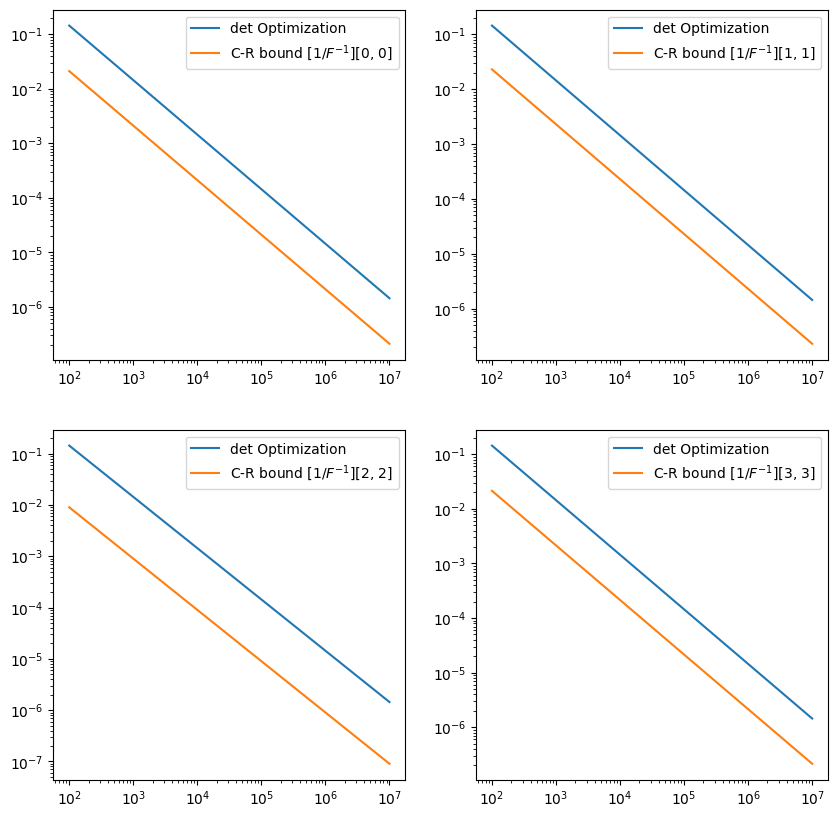

In [141]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

k = 10


for i, ax in enumerate(axs.flat):

    ax.plot(N, det_opt_scaling, label="det Optimization")
    # ax.plot(N, sql_scaling, label="SQL")
    ax.plot(
        N,
        inverse_matrix_scaling.T[i],
        label="C-R bound $ [1/F^{-1}]$" f"[{i}, {i}]",
    )
    # ax.plot(N, norm_inverse_matrix_scaling, label="Norm inverse")

    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.axvline(times[jnp.argmax(evolution_det_fim[k:])], alpha=0.7, color="indianred")

    ax.legend()

# plt.tight_layout()
plt.show()

In [135]:
factor_norm_inverse

Array(0.0001886, dtype=float32)

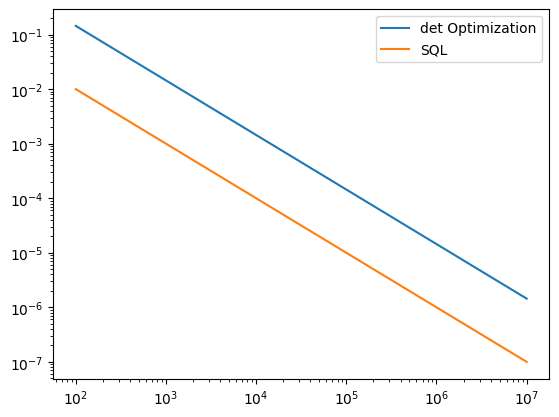

In [107]:
plt.plot(N, det_opt_scaling, label="det Optimization")
plt.plot(N, sql_scaling, label="SQL")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

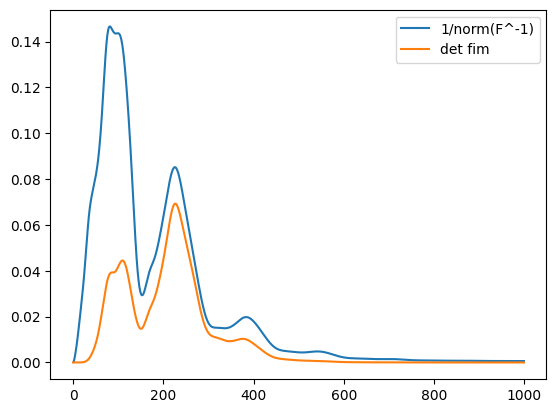

In [20]:
plt.plot(
    jax.vmap(lambda x: 1 / jnp.linalg.norm(x))(evolution_inverse_fim),
    label="1/norm(F^-1)",
)
plt.plot(evolution_det_fim, label="det fim")
plt.legend()
plt.show()

In [21]:
evolution_inverse_norm_fim = jax.vmap(lambda x: 1 / jnp.linalg.norm(x))(
    evolution_inverse_fim
)

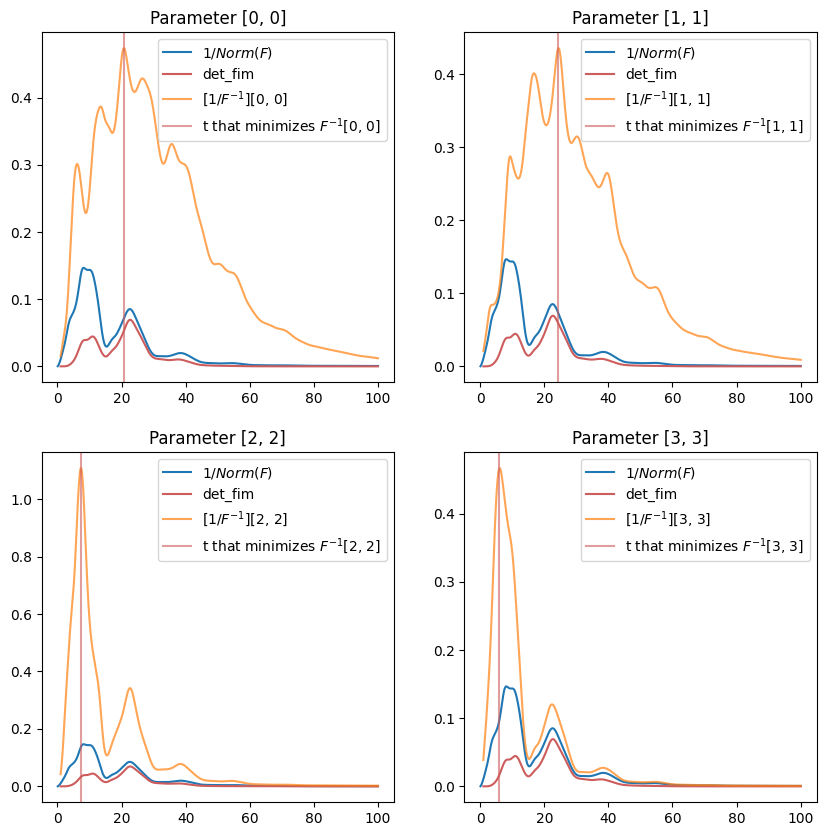

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

k = 10


for i, ax in enumerate(axs.flat):
    ax.plot(times, evolution_inverse_norm_fim, label="$1/Norm(F)$")
    ax.plot(
        times[k:], evolution_det_fim[k:], color="indianred", label="det_fim"
    )
    ax.plot(
        times[k:],
        1 / evolution_inverse_fim[k:, i, i],
        alpha=0.7,
        label="$[1/F^{-1}]$" f"[{i}, {i}]",
    )
    ax.axvline(
        times[jnp.argmin(evolution_inverse_fim[1:, i, i])],
        label="t that minimizes $F^{-1}$" f"[{i}, {i}]",
        alpha=0.6,
        color="indianred",
        # color=color_names[i],
    )
    ax.set_title(f"Parameter [{i}, {i}]")
    # ax.axvline(times[jnp.argmax(evolution_det_fim[k:])], alpha=0.7, color="indianred")

    ax.legend()

# plt.tight_layout()
plt.show()

In [23]:
jnp.argmin(evolution_inverse_fim[1:, 0, 0])

Array(206, dtype=int32)

In [24]:
jnp.mean(jnp.diag(times[jnp.argmin(evolution_inverse_fim[1:, :, :], axis=0)]))

Array(14.539539, dtype=float32)

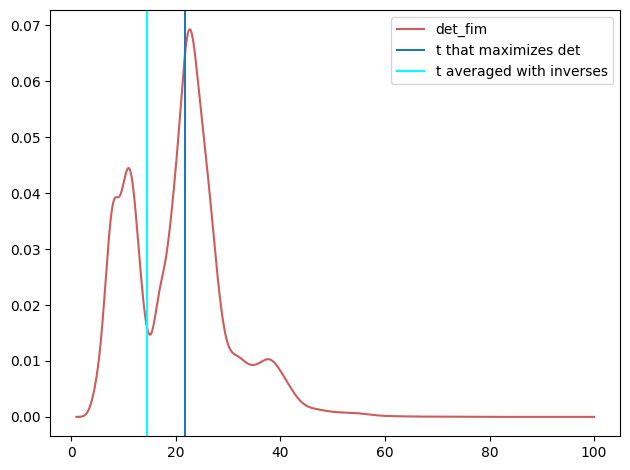

In [25]:
k = 10

fig, ax = plt.subplots()

color_names = ["violet", "limegreen", "royalblue", "tomato"]


for i in range(4):
    i
    # plt.plot(times[k:], 1/evolution_inverse_fim[k:, i, i])
    # plt.axvline(
    #     times[jnp.argmin(evolution_inverse_fim[1:, i, i])],
    #     # label=f"t for F^-1_{i, i}",
    #     alpha=0.6,
    #     # color=color_names[i],
    # )

plt.plot(times[k:], evolution_det_fim[k:], color="indianred", label="det_fim")
plt.axvline(
    times[jnp.argmax(evolution_det_fim[k:])], label="t that maximizes det"
)
plt.axvline(
    jnp.mean(
        jnp.diag(times[jnp.argmin(evolution_inverse_fim[1:, :, :], axis=0)])
    ),
    label="t averaged with inverses",
    color="cyan",
)


plt.legend()
plt.tight_layout()
plt.show()
# plt.plot(times[k:], evolution_det_fim[k:]/evolution_fim[k:, 0, 0])

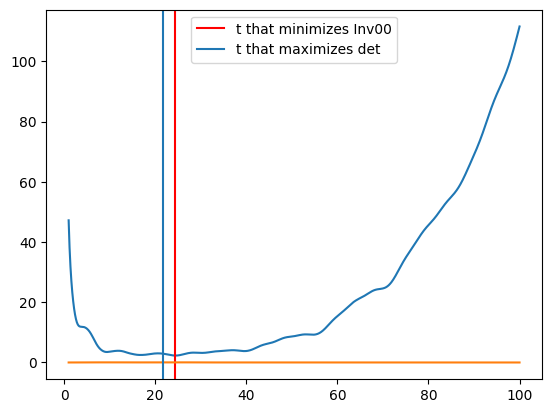

In [26]:
k = 10
plt.plot(times[k:], evolution_inverse_fim[k:, 1, 1])
plt.axvline(
    times[jnp.argmin(evolution_inverse_fim[1:, 1, 1])],
    label="t that minimizes Inv00",
    color="red",
)

plt.plot(
    times[k:],
    evolution_det_fim[k:],
)
plt.axvline(
    times[jnp.argmax(evolution_det_fim[k:])], label="t that maximizes det"
)

plt.legend()
plt.show()
# plt.plot(times[k:], evolution_det_fim[k:]/evolution_fim[k:, 0, 0])

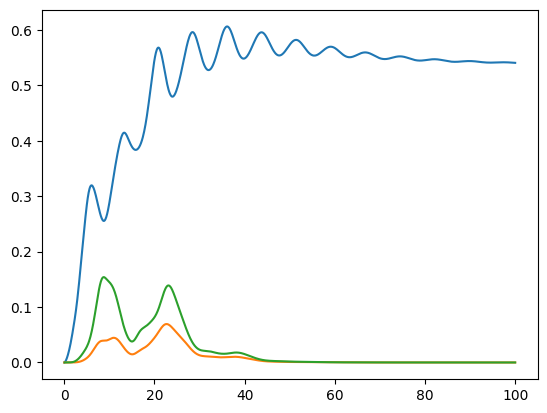

In [27]:
plt.plot(times, evolution_fim[:, 0, 0])
plt.plot(times, evolution_det_fim)
plt.plot(times, evolution_det_fim / evolution_fim[:, 0, 0])